In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


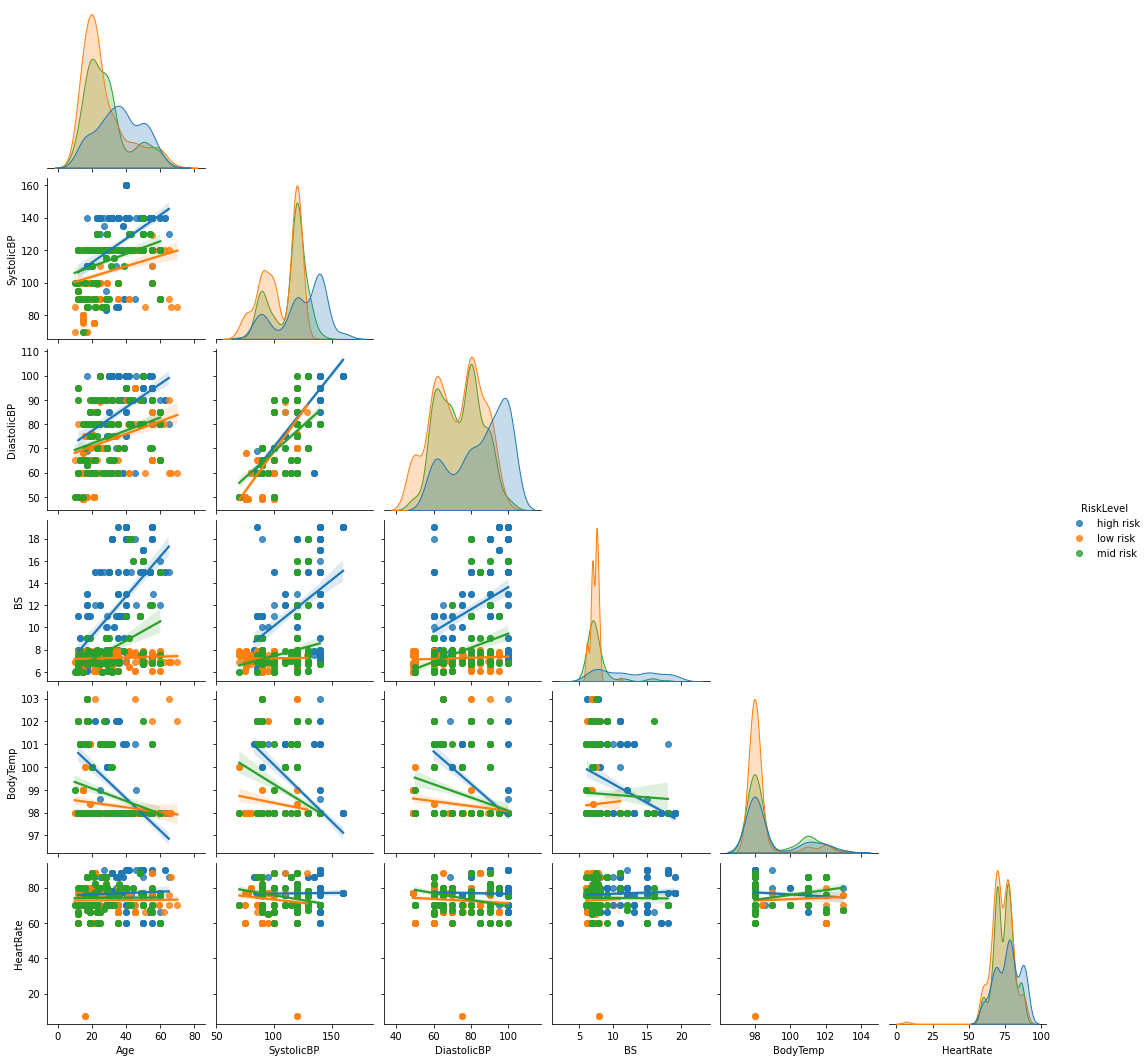

In [4]:
sns.pairplot(data=df,
             corner=True,
             hue='RiskLevel',
             kind='reg')

In [5]:
df['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [6]:
encode = {"RiskLevel" : {'high risk' : 3 , 'mid risk' : 2 , 'low risk' : 1}}

In [7]:
df = df.replace(encode)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


In [9]:
X = df.drop(columns="RiskLevel")
y = df['RiskLevel']
X.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [11]:
model_base = Pipeline([
    ('Model_Decision_Tree', DecisionTreeClassifier(random_state=42))
])

In [12]:
scores = cross_val_score(model_base, X = X_train , y = y_train , cv = 10, )
scores.mean()

0.853372478169226

In [13]:
model_rfc = Pipeline([
    ('RFC', RandomForestClassifier(random_state=42))
])

In [14]:
scores = cross_val_score(model_rfc, X = X_train , y = y_train , cv = 8, )
scores.mean()

0.8385386332750921

In [15]:
para_dict = {
    'criterion' : ['gini','entropy'],
    ##'splitter' : ['best','random'],
    'max_depth' : range(3,5),
    'min_samples_split' : range(5,15),
    'min_samples_leaf' : range(10,20)
}

In [16]:
model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                 param_grid=para_dict,
                                 cv = 10,
                                 refit=True)

In [17]:
model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 5),
                         'min_samples_leaf': range(10, 20),
                         'min_samples_split': range(5, 15)})

In [18]:
model.score(X_test,y_test)

0.6650246305418719

In [19]:
best_params = model.best_params_
model = DecisionTreeClassifier(**best_params)
model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=11,
                       min_samples_split=5)

In [20]:
import graphviz

In [21]:
dot_data = tree.export_graphviz(model, 
                                feature_names=X_train.columns,  
                                class_names=['Low Risk','Mid Risk','High Risk'], 
                                label = 'none',
                                filled=True, rounded=True,  
                                impurity=False,
                                leaves_parallel=True,
                                proportion=True,
                                special_characters=True,
                                out_file=None)


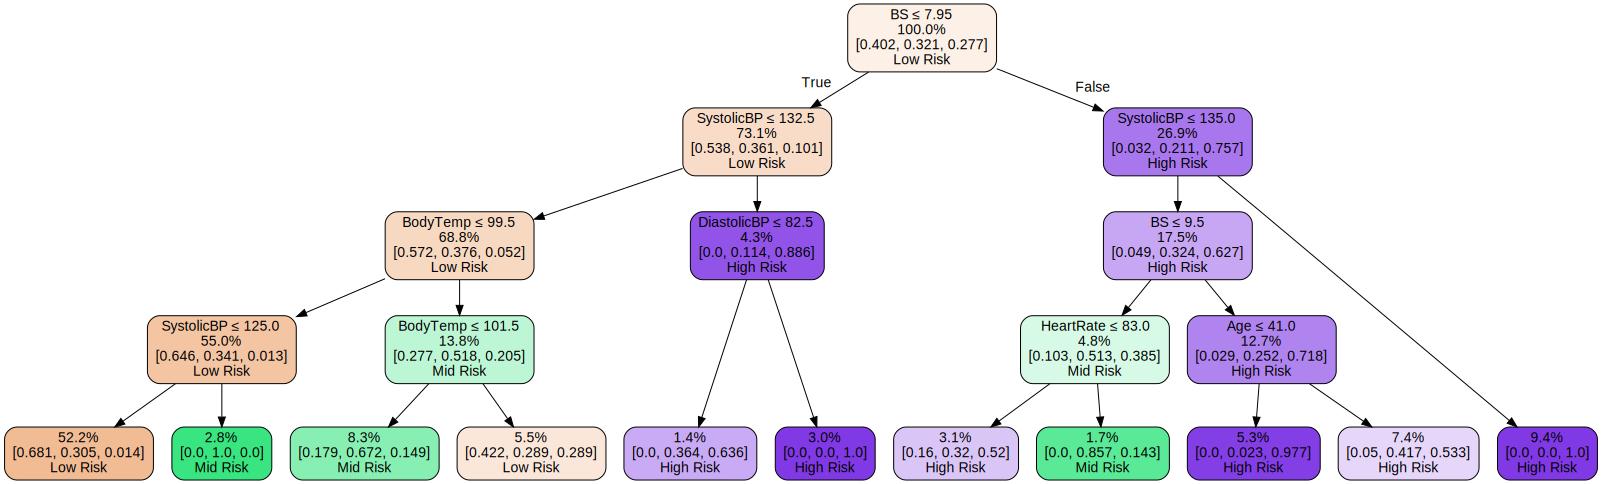

In [22]:
graph = graphviz.Source(dot_data,)
graph

In [23]:
df.iloc[0,0:-1]

Age             25.0
SystolicBP     130.0
DiastolicBP     80.0
BS              15.0
BodyTemp        98.0
HeartRate       86.0
Name: 0, dtype: float64

In [24]:
g = graphviz.Source(source=dot_data,format='png') 

In [25]:
g.save()
g.render(filename='best_model_graph', view=0, cleanup=1)

'best_model_graph.png'

In [33]:
text_representation = tree.export_text(model,feature_names=X_train.columns.tolist())
print(text_representation)

|--- BS <= 7.95
|   |--- SystolicBP <= 132.50
|   |   |--- BodyTemp <= 99.50
|   |   |   |--- SystolicBP <= 125.00
|   |   |   |   |--- class: 1
|   |   |   |--- SystolicBP >  125.00
|   |   |   |   |--- class: 2
|   |   |--- BodyTemp >  99.50
|   |   |   |--- BodyTemp <= 101.50
|   |   |   |   |--- class: 2
|   |   |   |--- BodyTemp >  101.50
|   |   |   |   |--- class: 1
|   |--- SystolicBP >  132.50
|   |   |--- DiastolicBP <= 82.50
|   |   |   |--- class: 3
|   |   |--- DiastolicBP >  82.50
|   |   |   |--- class: 3
|--- BS >  7.95
|   |--- SystolicBP <= 135.00
|   |   |--- BS <= 9.50
|   |   |   |--- HeartRate <= 83.00
|   |   |   |   |--- class: 3
|   |   |   |--- HeartRate >  83.00
|   |   |   |   |--- class: 2
|   |   |--- BS >  9.50
|   |   |   |--- Age <= 41.00
|   |   |   |   |--- class: 3
|   |   |   |--- Age >  41.00
|   |   |   |   |--- class: 3
|   |--- SystolicBP >  135.00
|   |   |--- class: 3



In [27]:
import pickle

In [28]:
filename = 'finalized_model.sav'
pickle.dump(model, open('pkl_at_risk_pregnancies', 'wb'))

In [29]:
loaded_model = pickle.load(open('pkl_at_risk_pregnancies', 'rb'))